## Train LSTM & RNN
#### Data preparation note
Stack short sequences ffrom many road segments together. Short sequences are obtained by breaking long time series into overlapping windows
 
|Shape | Meaning |
|------|---------|
|X_train: (N, seq_len, n_features)|N = total number of sequences across all TMCs|
|y_train: (N,)|Next-step travel time for each sequence|
|Optional tmc_id|To track which segment each sample came from|

#### Note
- log-transform target to log_tt_per_mile, model converges too fast, results flat prediction

##

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss

In [2]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))
print(X_full.columns)

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (118700, 31)
Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_unplanned', 'evt_cat_planned', 'miles', 'curve', 'offramp',
       'onramp', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week',
       'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend', 'evt_total',
       'speed_ratio', 'lag1', 'lag2', 'lag3', 'tt_per_mile',
       'lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile',
       'log_tt_per_mile', 'log_lag1_tt_per_mile', 'log_lag2_tt_per_mile',
       'log_lag3_tt_per_mile'],
      dtype='object')


In [23]:
# Full training pipeline
class LogSpaceMSE(Loss):
    def call(self, y_true, y_pred):
        y_true_log = tf.math.log(y_true + 1e-6)
        y_pred_log = tf.math.log(y_pred + 1e-6)
        # print(y_true_log, y_pred_log)
        return tf.reduce_mean(tf.square(y_true_log - y_pred_log))
    
def train_lstm(X_full, feature_cols, target_col, seq_len=6, stride=1,
               test_frac=0.2, hidden_units=64, dropout=0.2,
               batch_size=128, epochs=100, shuffle_train=True):
    """
    Full LSTM training pipeline:
      - Creates sliding window sequences across all TMCs
      - Chronologically splits into train/test by time (last test_frac fraction)
      - Uses internal normalization layer (acts like StandardScaler)
      - Trains and evaluates the LSTM

    Args:
        X_full (DataFrame): indexed by (tmc_code, time_bin)
        feature_cols (list): feature column names
        target_col (str): target column
        seq_len (int): lookback window
        stride (int): sliding window stride
        test_frac (float): fraction of data for test (chronological)
        shuffle_train (bool): whether to shuffle training samples
    """

    # === 1. Build sequences ===
    print("Preparing sequence data...")
    Xs, ys, meta = [], [], []
    for tmc, grp in X_full.groupby(level='tmc_code'):
        grp = grp.sort_index(level='time_bin')
        data = grp[feature_cols + [target_col]].to_numpy()
        times = grp.index.get_level_values('time_bin').to_numpy()

        for start in range(0, len(data) - seq_len, stride):
            Xs.append(data[start:start + seq_len, :-1])
            ys.append(data[start + seq_len, -1])
            meta.append((tmc, times[start + seq_len]))

    Xs = np.stack(Xs)
    ys = np.array(ys)
    meta = pd.DataFrame(meta, columns=['tmc_code', 'time_bin'])

    print(f"Generated {len(Xs)} total sequences from {X_full.index.get_level_values('tmc_code').nunique()} TMCs")

    # === 2. Chronological split (global, not per TMC) ===
    print("Splitting data chronologically per TMC...")

    train_idx, test_idx = [], []
    for tmc, grp in meta.groupby('tmc_code', sort=False):
        grp_sorted = grp.sort_values('time_bin')
        n = len(grp_sorted)
        n_test = max(1, int(n * test_frac))
        train_idx.extend(grp_sorted.index[:-n_test].tolist())
        test_idx.extend(grp_sorted.index[-n_test:].tolist())

    X_train, X_test = Xs[train_idx], Xs[test_idx]
    y_train, y_test = ys[train_idx], ys[test_idx]
    meta_train = meta.loc[train_idx].reset_index(drop=True)
    meta_test = meta.loc[test_idx].reset_index(drop=True)

    # === 3. Shuffle training samples (after splitting, not time-wise) ===
    if shuffle_train:
        idx = np.arange(len(X_train))
        np.random.shuffle(idx)
        X_train, y_train = X_train[idx], y_train[idx]
        meta_train = meta_train.iloc[idx].reset_index(drop=True)

    n_features = X_train.shape[2]

    # === 4. Build model with internal normalization layer ===
    print("Building LSTM model with normalization...")
    # Adapt normalization on training data
    normalizer = Normalization(axis=-1)
    normalizer.adapt(X_train.reshape(-1, n_features))  # <- works, not yet bound to input shape

    model = Sequential([
        Input(shape=(seq_len, n_features)),
        normalizer,
        LSTM(hidden_units, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
        # Dense(1, activation='softplus')  # ensure non-negative output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # === 5. Train model with random validation split ===
    n_val = int(0.1 * len(X_train))
    X_val, y_val = X_train[-n_val:], y_train[-n_val:]
    X_train_sub, y_train_sub = X_train[:-n_val], y_train[:-n_val]

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_sub, y_train_sub,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,  # shuffle again for each epoch
        callbacks=[es],
        verbose=1
    )

    # === 6. Evaluate ===
    print("Evaluating model...")
    y_pred = model.predict(X_test).squeeze()
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    mae  = np.mean(np.abs(y_test - y_pred))
    print(f"Test RMSE: {rmse:.3f}, MAE: {mae:.3f}")

    return model, history, (X_train, y_train, X_test, y_test, y_pred, meta_train, meta_test) # X_test, y_test, and y_pred still remain chronological order

In [32]:
# Simple LSTM model
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_cat_unplanned', 'evt_cat_planned']
# lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
lag_features = ['lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed', 'curve','onramp', 'offramp']
full_features = time_features + evt_features + lag_features + tmc_features

SEQ_LEN = 24          # past X hours → predict next hour
STRIDE = 1           # sliding window stride
TARGET_COL = 'tt_per_mile'
FEATURE_COLS = full_features
model, history, (X_train, y_train, X_test, y_test, y_pred, meta_train, meta_test) = train_lstm(X_full, FEATURE_COLS, TARGET_COL, seq_len=SEQ_LEN, shuffle_train=True)

Preparing sequence data...
Generated 117500 total sequences from 50 TMCs
Splitting data chronologically per TMC...
Building LSTM model with normalization...
Epoch 1/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 300.6109 - mae: 9.2319 - val_loss: 26.3695 - val_mae: 1.7671
Epoch 2/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 39.2621 - mae: 3.2138 - val_loss: 21.4431 - val_mae: 1.3362
Epoch 3/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 37.3950 - mae: 3.1230 - val_loss: 20.4927 - val_mae: 1.1928
Epoch 4/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 35.8240 - mae: 3.0736 - val_loss: 19.2622 - val_mae: 1.2620
Epoch 5/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 34.3337 - mae: 3.0461 - val_loss: 18.1539 - val_mae: 1.3177
Epoch 6/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 32.6812 - mae: 3.0016 - val_loss: 17.3487 - val_mae: 1.1693
Epoch 7/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 30.9214 - mae: 2.9274 - val_loss: 16.2811 - val_mae: 1.

In [24]:
meta_test.tmc_code.unique() 

array(['115+04177', '115+04178', '115+04179', '115+04180', '115+04181',
       '115+04182', '115+04183', '115+04184', '115+04185', '115+04186',
       '115+04187', '115+04188', '115-04177', '115-04178', '115-04179',
       '115-04180', '115-04181', '115-04182', '115-04183', '115-04184',
       '115-04185', '115-04186', '115-04187', '115-05165', '115N04177',
       '115N04178', '115N04179', '115N04180', '115N04181', '115N04182',
       '115N04183', '115N04184', '115N04185', '115N04186', '115N04187',
       '115N04188', '115N05165', '115P04177', '115P04178', '115P04179',
       '115P04180', '115P04181', '115P04182', '115P04183', '115P04184',
       '115P04185', '115P04186', '115P04187', '115P04188', '115P05165'],
      dtype=object)

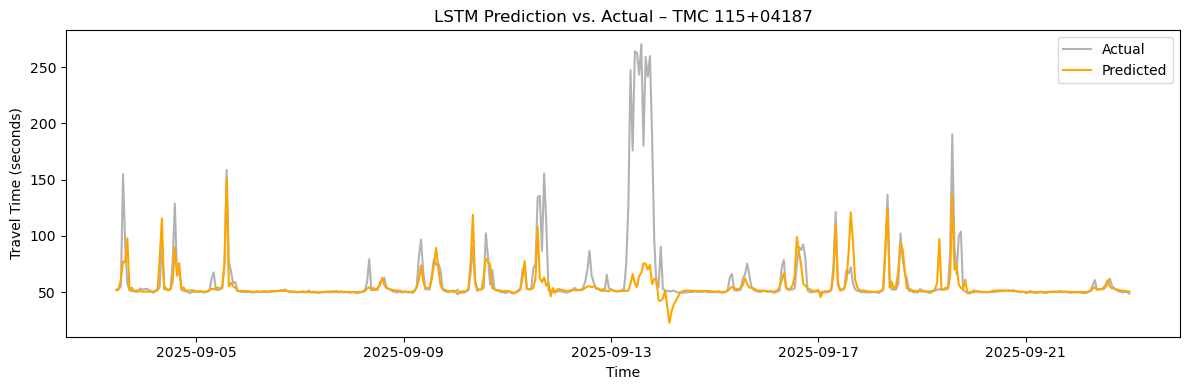

In [33]:
TMC = "115+04187"
tmc_results = (
    meta_test.assign(y_true=y_test, y_pred=y_pred)
             .query("tmc_code == @TMC")
             .sort_values('time_bin')
             .reset_index(drop=True)
)

plt.figure(figsize=(12, 4))
plt.plot(tmc_results['time_bin'], tmc_results['y_true'],
         label='Actual', color='gray', alpha=0.6)
plt.plot(tmc_results['time_bin'], tmc_results['y_pred'],
         label='Predicted', color='orange')
plt.title(f"LSTM Prediction vs. Actual – TMC {TMC}")
plt.xlabel("Time")
plt.ylabel("Travel Time (seconds)")
plt.legend()
plt.tight_layout()
plt.show()

2938/2938 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step


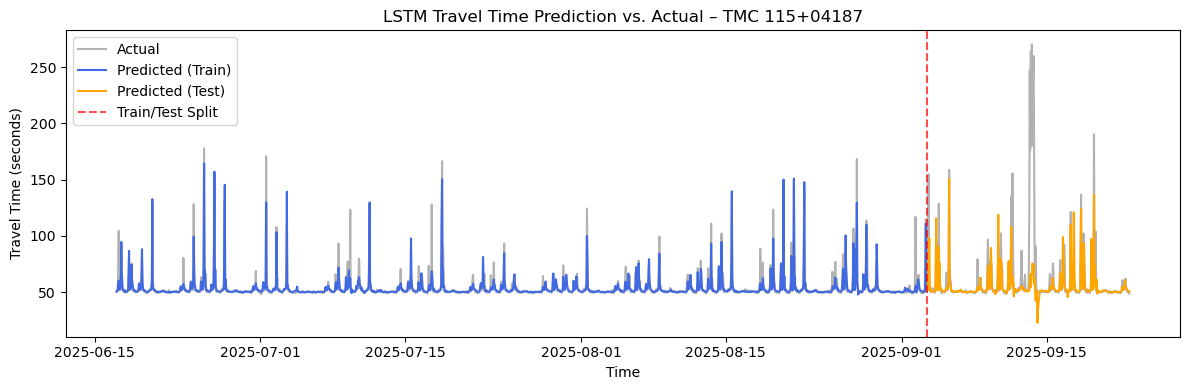

In [34]:

# TMC = "115+04177"

# Combine training and testing results with true + predicted
train_df = (
    meta_train.assign(y_true=y_train, y_pred=model.predict(X_train).squeeze())
              .query("tmc_code == @TMC")
              .sort_values('time_bin')
              .reset_index(drop=True)
)

test_df = (
    meta_test.assign(y_true=y_test, y_pred=y_pred)
             .query("tmc_code == @TMC")
             .sort_values('time_bin')
             .reset_index(drop=True)
)

# Concatenate for continuous timeline
full_df = pd.concat([train_df.assign(split='Train'),
                     test_df.assign(split='Test')],
                    ignore_index=True)

plt.figure(figsize=(12, 4))

# Plot actuals
plt.plot(full_df['time_bin'], full_df['y_true'],
         label='Actual', color='gray', alpha=0.6)

# Plot in-sample (training) predictions
plt.plot(train_df['time_bin'], train_df['y_pred'],
         label='Predicted (Train)', color='royalblue')

# Plot out-of-sample (testing) predictions
plt.plot(test_df['time_bin'], test_df['y_pred'],
         label='Predicted (Test)', color='orange')

# Vertical line separating train/test boundary
plt.axvline(x=test_df['time_bin'].min(),
            color='red', linestyle='--', alpha=0.7, label='Train/Test Split')

plt.title(f"LSTM Travel Time Prediction vs. Actual – TMC {TMC}")
plt.xlabel("Time")
plt.ylabel("Travel Time (seconds)")
plt.legend()
plt.tight_layout()
plt.show()

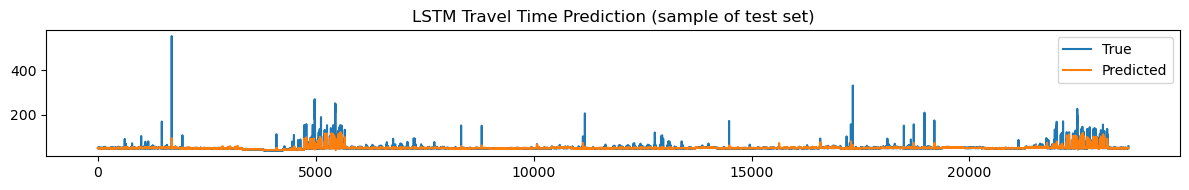

In [29]:
plt.figure(figsize=(12,2))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Travel Time Prediction (sample of test set)')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# save the trained model
import os

def save_training_outputs(
    model, history,
    X_train, y_train, X_test, y_test, y_pred,
    meta_train, meta_test,
    save_dir="../models/lstm_outputs"
):
    os.makedirs(save_dir, exist_ok=True)

    # === 1. Save model ===
    model_path = os.path.join(save_dir, "model.keras")
    model.save(model_path)
    print(f"✅ Model saved to {model_path}")

    # # === 2. Save training history ===
    # hist_path = os.path.join(save_dir, "training_history.json")
    # with open(hist_path, "w") as f:
    #     json.dump(history.history, f)
    # print(f"✅ Training history saved to {hist_path}")

    # === 3. Save arrays ===
    npz_path = os.path.join(save_dir, "results.npz")
    np.savez_compressed(
        npz_path,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        y_pred=y_pred
    )
    print(f"✅ Data arrays saved to {npz_path}")

    # === 4. Save metadata ===
    meta_train.to_parquet(os.path.join(save_dir, "meta_train.parquet"))
    meta_test.to_parquet(os.path.join(save_dir, "meta_test.parquet"))
    print(f"✅ Metadata saved to Parquet format")

    print(f"\nAll outputs saved in: {os.path.abspath(save_dir)}")

save_training_outputs(
    model, history,
    X_train, y_train, X_test, y_test, y_pred,
    meta_train, meta_test,
    save_dir="../models/lstm_outputs"
)

✅ Model saved to ../models/lstm_outputs/model.keras
✅ Data arrays saved to ../models/lstm_outputs/results.npz
✅ Metadata saved to Parquet format

All outputs saved in: /Users/ywan1649/Documents/03_Research/Active/wzdx/models/lstm_outputs


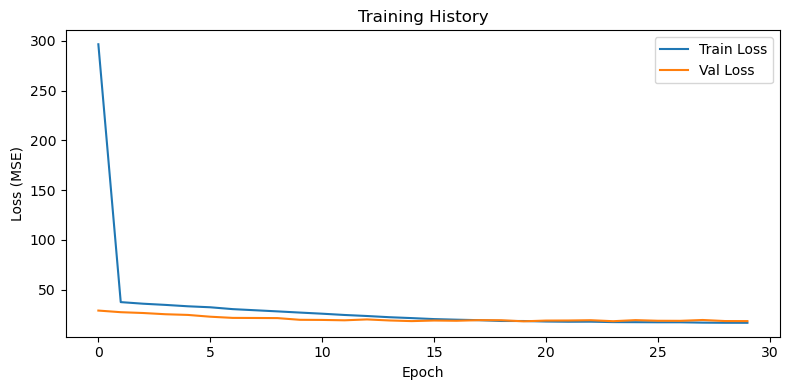

In [31]:
# plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
X_full.columns

Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure',
       'evt_cat_obstruction', 'evt_cat_misc', 'miles', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin',
       'hour_of_week_cos', 'is_weekend', 'evt_total', 'speed_ratio', 'lag1',
       'lag2', 'lag3', 'tt_per_mile', 'lag1_tt_per_mile', 'lag2_tt_per_mile',
       'lag3_tt_per_mile'],
      dtype='object')